# Computational Phenotyping

_by Thomas Walter and Joseph Boyd, Mines ParisTech, Institut Curie, INSERM U900._

In this notebook, we will apply unsupervised and supervised learning techniques in order to analyze phenotypic data. The phenotypic data comes in the form of manually annotated cell morphologies: to each cell a manual annotator has assigned one phenotypic class, such as `interphase`, `prometaphase`, ... These classes are mutually exclusive.


## Training data

The training data was generated with [CellCognition](https://www.cellcognition-project.org). CellCognition is a tool for the analysis of High Content Screening data and computational phenotyping. In particular, it is also very useful for manual annotation of cellular data. The training set we work on in this notebook has been generated by Beat Neumann and Thomas Walter for the study published in _Neumann, Walter, et al._. The labels have been manually assigned to nuclei, after segmentation.

**References:**

* *Neumann, B., Walter, T., Hériché, J.-K., Bulkescher, J., Erfle, H., Conrad, C., … Ellenberg, J. (2010). Phenotypic profiling of the human genome by time-lapse microscopy reveals cell division genes. Nature, 464(7289), 721–7. https://doi.org/10.1038/nature08869*

## Class definitions

We next would like to load the class definitions. They are saved as a tab-delimited text file, containing:
- the label of the class
- the string representation of the class
- the color that has been chosen during annotation
 
We will therefore import these definitions by reading the `csv` file. For this, we use a helper function defined in `data_utils.py`: `read_class_definition` reads the class names, their corresponding labels and the assigned colors. This allows us to ensure some consistency throughout this notebook.

In [1]:
from src import data_utils
folder = './data/classifier/Classifier_full_2015_06_04_b'
class_definition = data_utils.read_class_definition(folder)

`class_definition` has three entries: `label_to_name` (dictionary with class labels as keys and class names as values), `name_to_label` (dictionary with class names as keys and class labels as values) and `lut` (dictionary with class labels as keys and colors as values). 

In [3]:
class_definition['name_to_label']

{'Interphase': 1,
 'Large': 2,
 'Elongated': 3,
 'Shape1': 4,
 'Shape3': 5,
 'Grape': 6,
 'Metaphase': 7,
 'Anaphase': 8,
 'MetaphaseAlignment': 9,
 'Prometaphase': 10,
 'ADCCM': 11,
 'Apoptosis': 12,
 'Hole': 13,
 'Folded': 14,
 'SmallIrregular': 15,
 'OutOfFocus': 16}

We are going to discuss these classes when looking at images.

## Image import

The first step a data anlyst takes is always to look at the data. `read_image_data` reads the crops of all samples in the training set into one array of size `(N, width, height)`. `y` is the output vector (labels).

In [4]:
from src import data_utils
import numpy as np

class_definition = data_utils.read_class_definition(folder)
images, output = data_utils.read_image_data_from_sample_folder('./data/classifier/Classifier_full_2015_06_04_b')
X_img, y_img = data_utils.read_image_data('./data/classifier/Classifier_full_2015_06_04_b')

In [6]:
print(X_img.shape)
print(y_img.shape)

(3277, 64, 64)
(3277,)


We see that in our training set, we have 3277 annotated images. Each crop is 64 times 64. However, morphologies can have different sizes. It can happen that a nucleus does not fit inside the crop or that cells in the neighborhood are also captured.

Class: Prometaphase


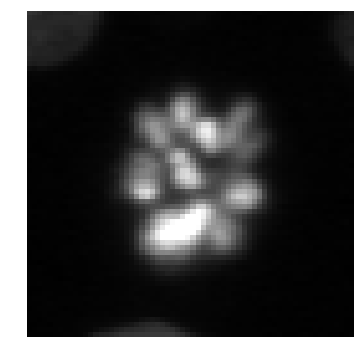

In [7]:
from src import vis_utils
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
idx = np.random.randint(len(X_img))
vis_utils.plot_image(ax, X_img[idx], class_definition['label_to_name'][y_img[idx]])

We can now plot different classes together in an array using the provided function `plot_array`. 

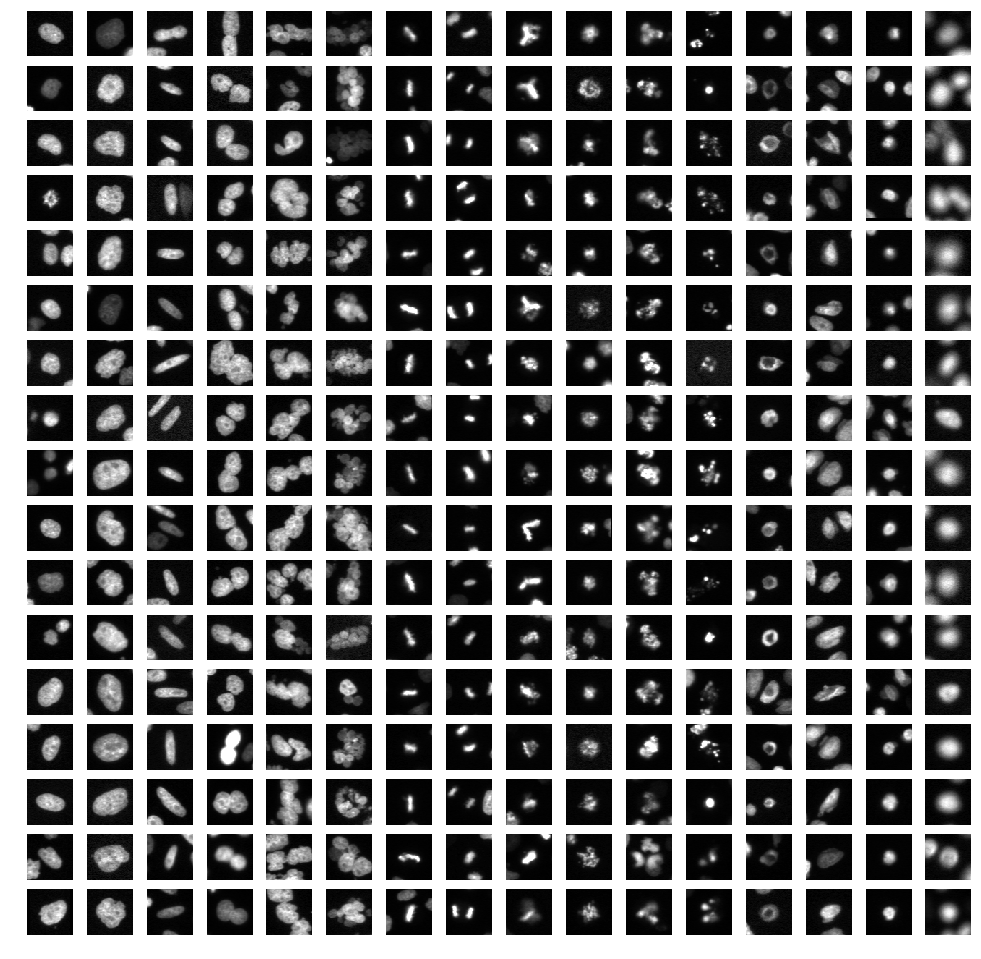

In [8]:
fig = plt.figure(figsize=(17, 17))
vis_utils.plot_array(fig, X_img, y_img, samples_per_class=17)

The classes have the following meaning: `Interphase` is normally related to the cell cycle and regroups all non-mitotic phases (G1, S, G2). Here however, we take `Interphase` as a shortcut for normal interphase, meaning that interphase nuclei are nuclei of normal, non-dividing cells. `Large` nuclei are ... large! `Elongated` nuclei are also non-dividing but have a an elongated shape, `Shape1` refers to two nuclei in close proximity (typically arising from cytokinesis defects), `Shape3` is an abnormal nuclear morphology usually resulting from segregation defects (i.e. the nuclei are not properly distributed to the daughter nuclei during division and / or the nuclear envelope does not form correctly). `Grape` is a variant of such a morphology, involving micronucleation. Then there come normal and abnormal mitotic phases: `Metaphase`, `Anaphase`, `MAP` (Metaphase Alignment Problems), `Prometaphase`, `ADCCM` (similar to `MAP`). Further morphological classes are: `Apoptosis` (cell death), `Hole`, `Folded` and `SmallIrregular`, all linked to problems in nuclear architecture. Finally, there is `OutOfFocus`, which does not require an explanation.

## Feature import

Now, we load the feature data. The CellCognition software saves the training set data as an `arff` file. In this file, we have all features for the annotated training samples and the class of each sample, saved in the last column.

In [9]:
from scipy.io import arff
import pandas as pd
import numpy as np

data = arff.loadarff('./data/classifier/Classifier_full_2015_06_04_b/data/features.arff')
df = pd.DataFrame(data[0])

df.head()

,ch_acd,ch_area_ratio,ch_cc,ch_max_val_0,ch_max_val_1,ch_max_val_2,ch_mean_area,ch_rugosity,ch_thresh_cc,ch_variance_area,...,n_wdist,n_wiavg,perimeter,princ_gyration_ratio,princ_gyration_x,princ_gyration_y,roisize,skewness_x,skewness_y,class
0,0.079492,0.959924,9.0,0.009940,0.009940,0.002982,4.222222,0.979730,0.0,9.728395,...,180.225646,3.102887,148.0,0.617221,0.360089,0.222255,1006.0,0.023754,0.028220,"b""'Large'"""
1,0.099301,0.959150,7.0,0.019591,0.005111,0.005111,6.714286,0.987952,1.0,46.775510,...,200.868825,2.772098,166.0,0.706883,0.337315,0.238442,1174.0,0.007011,0.081461,"b""'Large'"""
2,0.095908,0.955323,7.0,0.012935,0.010945,0.007960,6.285714,0.986111,0.0,17.918367,...,184.286567,3.399890,144.0,0.587506,0.369029,0.216807,1005.0,0.003707,0.039309,"b""'Large'"""
3,0.062106,0.954070,10.0,0.009750,0.009141,0.006703,7.300000,0.971154,0.0,25.810000,...,307.302255,1.790498,208.0,0.582137,0.373695,0.217541,1641.0,0.100315,0.086161,"b""'Large'"""
4,0.047905,0.899375,12.0,0.075747,0.008339,0.007644,13.000000,0.919192,1.0,848.833333,...,277.010424,1.889748,198.0,0.629768,0.370275,0.233187,1439.0,0.000987,0.127260,"b""'Large'"""


The `arff`-file we have imported contains both the class labels and the features. Obviously, we need to separate class labels from features in order to train classifiers, etc. We will therefore create a design matrix $X$ containing all columns of the data frame except the last and an $y$ vector containing the class labels (where we take the labels from class_definition, rather than the string representation).

In [10]:
y = np.array([class_definition['name_to_label'][x.decode("utf-8").strip('\'')] for x in df['class']])

In [12]:
X = df.drop('class', axis=1)

In [13]:
X.shape

(3277, 209)

We have now built our training set. We have 3277 samples (annotated nuclei) and 209 features for each.

## Data Cleaning and Preprocessing

The next step is to check whether there are `Nan`'s in the data. `Nan` means "not a number"; this typically happens if a feature value was not defined for some reason (e.g. division by zero). 

In [14]:
nb_nans = np.isnan(X).sum().sum()

In [15]:
print ('Number of Nan in the data: %i' % nb_nans)

Number of Nan in the data: 0


We see that there are no `Nan`s, so we can proceed. It must be noted that some learning algorithms can deal with `Nan`s, but often it is worth thinking about how to avoid them altogether, if possible. This is of course only possible if the data scientist can control the entire workflow.

The next thing to check is whether there are features with zero-variance. They certainly contain absolutely no information (they are constant over all classes), and nothing can be learned from them. 

In [16]:
X.columns[np.where(np.std(X)==0)]

Index([], dtype='object')

Apparently, there is no feature with variance 0. In general, any feature with variance 0 can be safely removed: nothing can be learned from the training set with respect to this feature.

We next normalize the data. We clearly saw that the different features we are using have very different ranges (some are between 0 and 1, others can reach very high values). Again, data normalization is not necessary for all machine learning algorithms. For some however, it is absolutely essential. Imagine for instance that you just calculate the Euclidean distance between data points $\|x_i - x_j\|_2$ (for instance for the purpose of clustering or visualization). In this case a feature with absolute values would completely dominate this metric. Here we use a standard normalization (zero mean and unity variance). If $x_j$ is one feature (column of $X$), we define $x^{norm}_j$ as:

\begin{equation}
x^{norm}_j = \frac{x_j - \mu(x_j)}{\sigma_{x_j}}  
\end{equation}

In [17]:
Xnorm=(X-X.mean())/X.std()

In [18]:
np.mean(Xnorm).head()

ch_acd          -1.787605e-15
ch_area_ratio    2.815877e-14
ch_cc            1.785436e-15
ch_max_val_0    -6.607809e-16
ch_max_val_1     8.948865e-16
dtype: float64

In [19]:
np.std(Xnorm).head()

ch_acd           0.999847
ch_area_ratio    0.999847
ch_cc            0.999847
ch_max_val_0     0.999847
ch_max_val_1     0.999847
dtype: float64

From now on, we work only on normalized features (i.e. we omit $norm$ in the formulas and set `X` to `Xnorm`.

In [20]:
X = Xnorm

## Visualization of the data and unsupervised analyses

We next turn to look at the data and show several ways of visually analyzing the data set. While this is often neglected in theoretical talks, looking at the data is usually an important part of a data scientist's work. It must be noted that in many real-world applications, in particular in biology, the definition of classes is not necessarily obvious and can undergo some modification during a project's lifetime. It is therefore important to get an idea about the trends in your data.

#### Plotting features

One way of looking at the data is to visualize joint distributions of features via scatterplots of feature pairs. For this, we use the function `make_scatterplot` from `vis_utils.py`. 

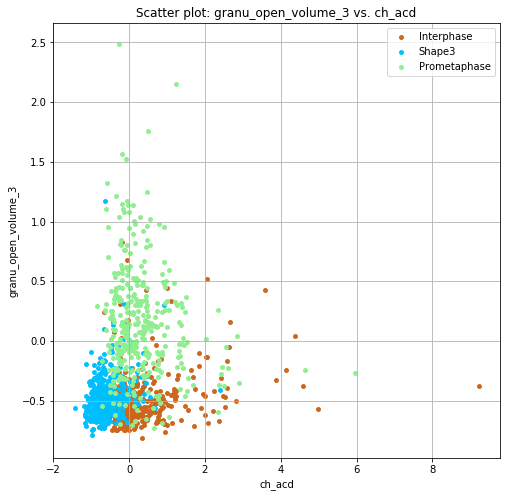

In [22]:
vis_utils.make_scatterplot(X, y, 'ch_acd', 'granu_open_volume_3', ['Interphase', 'Shape3', 'Prometaphase'], class_definition=class_definition)

Here, we plot a texture feature (morphological granulometries of size 3) and the number of pixels, i.e. one shape and one texture descriptor. We see that these features are quite discriminative between these classes. Not surprisingly, the pixelsize is capable of distinguishing between polylobed and interphase / prometaphase and the texture feature is capable of distinguishing prometaphase from interphase / polylobed. So we see that there is signal, but we also notice that the classes are far from being separable (by taking just these two features).

Sometimes, you might be tempted to reduce the number of features by removing features with little or no discriminative power and features that are strongly correlated to other features, as they -  so the idea - convey similar information. Let us take for instance 2 features describing second order statistics (`h1_2VAR` and `h4_1VAR`) and calculate the overall correlation.

In [23]:
np.corrcoef(X['h1_2VAR'], X['h4_2VAR'])

array([[1.        , 0.94375915],
       [0.94375915, 1.        ]])

We thus see that we get a strong correlation of these two features (0.92) suggesting that we could safely remove one of them without loosing much information.

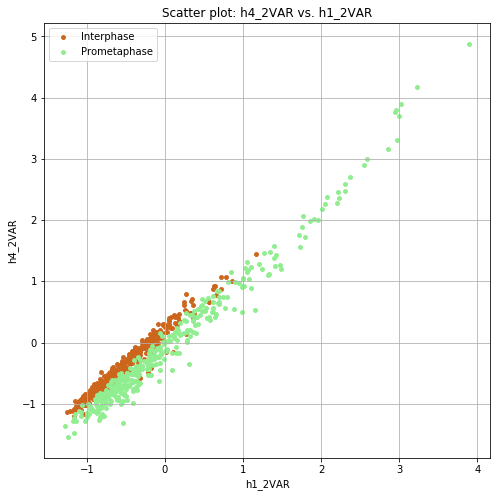

In [24]:
vis_utils.make_scatterplot(X, y, 'h1_2VAR', 'h4_2VAR', ['Interphase', 'Prometaphase'], class_definition=class_definition)

<font color=red> *How do you interpret this plot? Are these features useful?*</font>

We see from this scatterplot, that in addition to being highly correlated, both features are - when taken separately - not discriminative for these two classes. However, when we consider them together, they allow us to separate the two classes with reasonable accuracy. This is therefore a good example of the danger of applying such ad hoc techniques in order to reduce features.

#### Principal Component Analysis (PCA)

Another way of visualizing the data is to find a low dimensional reprentation. There are many methods in order to achieve this goal. The two most popular methods are Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE). In the following, we will apply these methods on our training data.

PCA projects the feature data onto a space where all components are orthogonal to each other and have maximal variance.

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

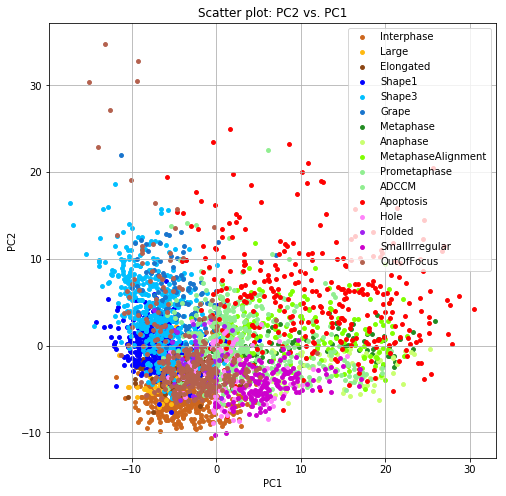

In [27]:
pc_df = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])
vis_utils.make_scatterplot(pc_df, y, 'PC1', 'PC2', list(class_definition['name_to_label'].keys()), class_definition=class_definition)

<font color=red> *Observations? Which classes would you expect to be difficult to classify correctly? How do you interpret the different region sizes occupied by different classes?*</font>

We observe that some classes are relatively well separated, others have a strong overlap. Interestingly, we also see that the space different classes occupy is very different for different classes. `Apoptosis` for instance seems to cover a large region in the feature space. Indeed, this is a highly variable class: dead cells can have a highly variable appearance.

#### t-distributed stochastic neighbor embedding

Next, we turn to a newer projection technique which is widely used in Machine Learning, but also in Computational Biology (in particular for sequencing data): t-SNE. Loosely speaking, one considers the probabilities $p_{ij}$ of two points $x_i$ and $x_j$ to be neighbors. t-SNE aims at finding a low-dimensional feature space, where the distribution of the corresponding $q_{ij}$ (the probability that $x^\prime_i$ and $x^\prime_j$ are neighbors in the low-dimensional feature representation) are as close as possible to $p_{ij}$ in the sense of KL-divergence:
\begin{equation}
KL(P\|Q) = \sum_{i\not= j}p_{ij}\log\frac{p_{ij}}{q_{ij}}
\end{equation}

In [31]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X)

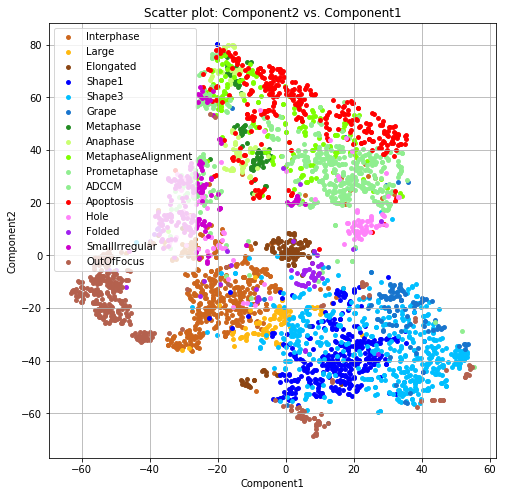

In [32]:
X_emb_df = pd.DataFrame(X_embedded, columns=['Component1', 'Component2'])
vis_utils.make_scatterplot(X_emb_df, y, 'Component1', 'Component2', list(class_definition['name_to_label'].keys()), class_definition=class_definition)

<font color=red> *How does this compare to the results obtained by PCA?*</font>

<font color=red> *Test different values of perplexity (2, 10, 30, 50).*</font>

We observe that the grouping of the points corresponds much more to the actual class labels. We also observe that the distances between points are very different. While in PCA, the interphase cluster was very small, the apoptosis cluster occupied a large space. Here, the apoptosis cluster is much smaller, while the interphase cluster is becoming larger. We also observe that some classes seem to be difficult to separate by unsupervised techniques (they do not form individual clusters), in particular `MAP` that mixes happily with `Prometaphase` and `Apoptosis`. Furthermore, we see that `Anaphase` and `Metaphase` do not form natural clusters, but their distribution seems to be shifted (albeit overlapping). Such a scenario indicates that probably these classes would have been hard to find in an unsupervised setting but may be relatively easy to separate in a supervised setting.

#### Hierarchical clustering

As the heading indicates, this is not primarily a data visualization technique, but a method for unsupervised learning (i.e. a method to identify classes from data without annotation). Hierarchical clustering however has also nice visualization properties, because we can visualize the nested structures in our data and also display the feature combinations corresponding to the individual clusters in so scalled heatmaps. Thanks to its power for exploratory data analysis, hierarchical clustering is widely used in biology. 

In [33]:
import seaborn as sns

In [34]:
colorvec = [class_definition['colors'][label] for label in y]
cmap = sns.diverging_palette(10, 220, sep=80, n=30)

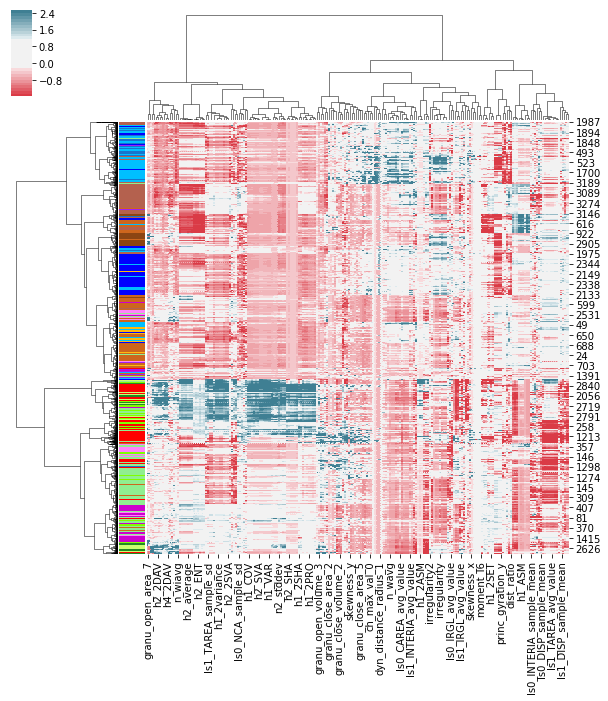

In [38]:
g = sns.clustermap(X, method='ward', metric='euclidean', 
                   row_colors=colorvec, robust=True, cmap=cmap)

<font color=red> *Try different agglomeration functions: single, complete, average, centroid, Ward (check in the sklearn documentation, what they mean and conclude, which one you would like to use).* </font>

Again, we observe that some classes can be well distinguished, others are clustered together. When interpreting such a plot, it is essential to also look at the dendrogram. Actually, the true clustering information is represented by the dendrogram and not by the order of the rows. Indeed, we could flip the cluster order at any merging point of the dendrogram without changing the clustering result provided by the hierarchical clustering. 

In the above example we used Ward's method for agglomeration and euclidean distance (`method="ward"`, `metric="euclidean"`). In an unsupervised setting, we could certainly infer some of these groups from the data set without manual annotation. Others - as mentioned above - do not form individual clusters. In this case, it is essential to impose prior knowledge in form of manual annotations.

## Supervised Learning

We will now train classifiers on our training set. Here, we train Random Forest Classifiers (RF) and Support Vector Machines (SVM) in order to recognize nuclear morphologies.

#### Random Forests

Random Forests are ensemble methods, where decision trees are trained on random subsets of the training data, where each split is performed on one feature. This feature is chosen from a random subset of the features in order to optimize the purity of the resulting sets.

In [39]:
from sklearn.ensemble import RandomForestClassifier

Now, we need to define the hyperparameters. In practice, on our kind of data, the most important parameter to be set is the number of trees in the forest. In general, the higher this number the better it is, but the resulting classifier will be slower also. Importantly, this parameter does not only affect training time, but also prediction time. For us however, this is not critical, and we set this parameter to 200. The second parameter is the `oob_score` which indicates whether to calculate the out-of-bag error. This is an error wich is only calculated on those samples that were left out for training the tree. Using the out-of-bag error allows us to avoid time-consuming cross-validation.

In [49]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

Now, we can train our classifier. 

In [50]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [51]:
print('overall accuracy: %.2f' % rf.oob_score_)

overall accuracy: 0.84


<font color=red> *Try different values for `n_estimators`. What do you observe?* </font>

We will now calculate the confusion matrix. 

In [52]:
prediction_result = rf.oob_decision_function_

In [53]:
classification_result = np.argmax(prediction_result, axis=1)
class_labels = np.array(list(class_definition['label_to_name'].keys()))
class_names = list(class_definition['name_to_label'])
print(class_labels)
print(classification_result)
print(class_names)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  1  1 ... 15  0 15]
['Interphase', 'Large', 'Elongated', 'Shape1', 'Shape3', 'Grape', 'Metaphase', 'Anaphase', 'MetaphaseAlignment', 'Prometaphase', 'ADCCM', 'Apoptosis', 'Hole', 'Folded', 'SmallIrregular', 'OutOfFocus']


/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


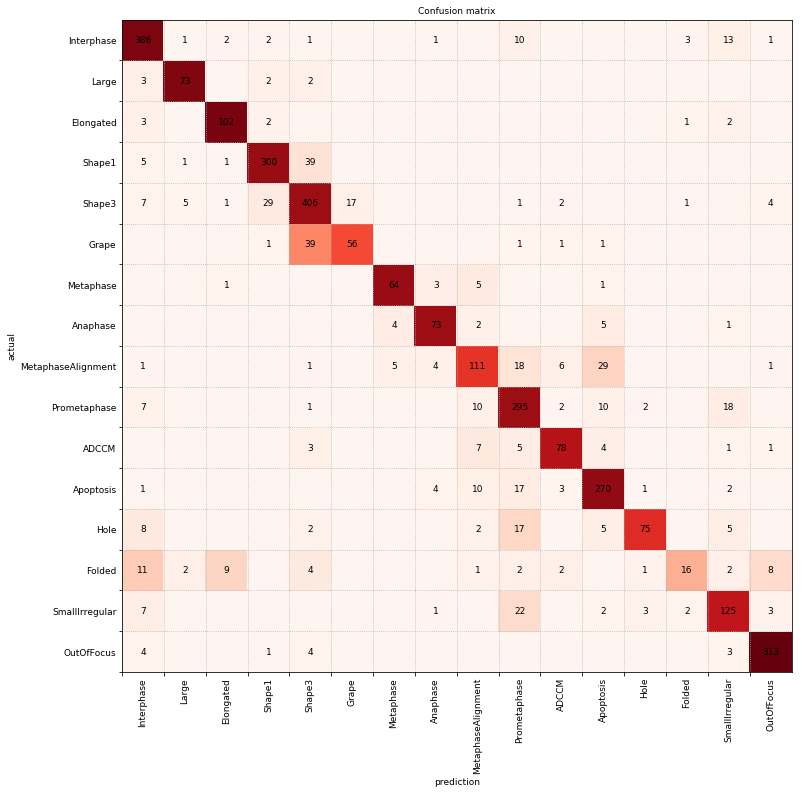

In [55]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y, class_labels[classification_result])

fig, ax = plt.subplots(figsize=(12, 12))
vis_utils.plot_confusion_matrix(ax, cm_rf, class_names, title='Confusion matrix', fontsize=9)


#### Support Vector Machines (SVM)

Here, training is formulated as a convex optimization problem under constraints:

\begin{eqnarray*}
\min_{w,\xi} & & \|w\|^2 + C \sum_{i=1}^{N}\xi_i\\
\mbox{subject to} & & y_i(w^Tx_i + b) \geq 1 - \xi_i \quad i = 1, \ldots, N \\
& & \xi_i \geq 0 \quad i = 1, \ldots, N
\end{eqnarray*}

The only parameter to be fixed is $C$, which controls the compromise between classifcation errors and regularization (the higher $C$ is chosen, the more weight is given to correct classification of training samples). There is no way of guessing $C$ and so we need to test different values of $C$ and choose the value that leads to the best performance. 

In [56]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [57]:
clf = svm.SVC(C=1, kernel='linear')

It is very important to evaluate the performance of the classifier by cross-validation: the training error is not equal to the test error. We are going to show this. First, we calculate the training error.

In [58]:
clf.fit(X,y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
print('accuracy measured on the training set: %.2f' % np.mean(clf.score(X,y)))

accuracy measured on the training set: 0.99


In [60]:
score = cross_val_score(clf, X, y, cv=10)

In [61]:
print('accuracy measured by 10-fold cross validation: %.2f' % np.mean(score))

accuracy measured by 10-fold cross validation: 0.84


<font color=red> *How do you explain this difference? Which of the values is more realistic?* </font>

/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


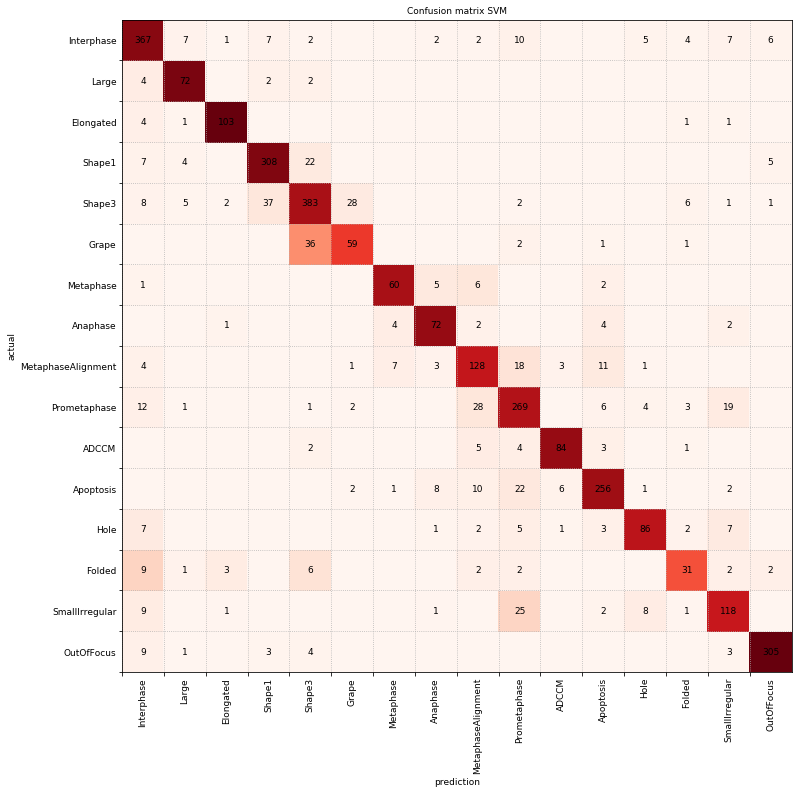

In [62]:
from sklearn.model_selection import cross_val_predict
res = cross_val_predict(clf, X, y)

cm_rf = confusion_matrix(y, res)

fig, ax = plt.subplots(figsize=(12, 12))
vis_utils.plot_confusion_matrix(ax, cm_rf, class_names, title='Confusion matrix SVM', fontsize=9)


As expected, we see that the performance on the training set is better than on the test set. Indeed, evaluating the performance on the training set is a typical mistake in machine learning, as this always gives overoptimistic results. While in this case, this was easy to avoid, it is sometimes more challenging to know whether our performance evaluation is correct in that it does not intermingle training and test set.

Here, we obtain a very similar result to what we obtained from the RF classifier, even though we use a linear kernel and did not yet optimize the parameter $C$. This is not a typical situation however: in most cases, optimization of $C$ is crucial. 

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
parameters = {'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 500]}

In [65]:
gs = GridSearchCV(clf, parameters, cv=10)

In [66]:
gs.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [67]:
gs.best_score_

0.8596277082697589

In [68]:
gs.cv_results_['mean_test_score']

array([0.85413488, 0.85962771, 0.85840708, 0.85169362, 0.84375954,
       0.83826671, 0.83613061, 0.83552029, 0.83552029])

The result is that we gain roughly 2% by performing this grid search (not dramatic, but also not negligible). 

<font color=red> *Train a classifier on the principal components. Plot the accuracy depending on the number of the principal components used. For 4 components, test the effect of the parameter C.* </font>